In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
import ProgressMeter
using LinearAlgebra
using WAV
using AIDA

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling AIDA [02ab3c64-7f6e-4624-92b1-4056b28faae1]
└ @ Base loading.jl:1317


In [2]:
# load bar sound
br, fs = wavread("../sound/environment/bar.wav");
# load train sound
tr, fs = wavread("../sound/environment/train.wav")
# load white noise
wn, fs = wavread("../sound/environment/white_noise_1e-5.wav")

# load mixed
mx, fs, _ = wavread("../sound/switching_context/bar_train_bar.wav")

([-0.0019226660969878231; -0.005615405743583483; … ; -0.0067445905941953795; -0.0025940733054597613], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x49, 0x6e, 0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a])])

In [3]:
br_seg = get_frames(br, fs)
tr_seg = get_frames(tr, fs)
wn_seg = get_frames(wn, fs)
mx_seg = get_frames(mx, fs);

downsample = 1;

In [4]:
inputs, outputs = ar_ssm(br, 2)
inputs, outputs = inputs[1:downsample:end], outputs[1:downsample:end]
br_γ, br_θ, br_fe = ar_inference(inputs, outputs, 2, 10, 1.0, 1.0)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


(Marginal(GammaShapeRate{Float64}(a=10559.5, b=1.2121356299795694)), Marginal(MvNormalWeightedMeanPrecision(
xi: [21471.54731568715, 17128.653500165095]
Λ: [23934.08068587043 21471.48545686268; 21471.48545686268 23933.724778559936]
)
), [-61086.02709745428, -65822.19954133434, -65822.31749947384, -65822.31749947398, -65822.31749947721, -65822.31749947698, -65822.31749947698, -65822.31749947695, -65822.31749947698, -65822.31749947695])

In [5]:
inputs, outputs = ar_ssm(tr, 2)
inputs, outputs = inputs[1:downsample:end], outputs[1:downsample:end]
tr_γ, tr_θ, tr_fe = ar_inference(inputs, outputs, 2, 10, 1.0, 1.0)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


(Marginal(GammaShapeRate{Float64}(a=10559.5, b=1.9376162964480612)), Marginal(MvNormalWeightedMeanPrecision(
xi: [58999.27323944256, 50828.09625132885]
Λ: [64754.58060332057 58999.360162059704; 58999.360162059704 64754.368055315164]
)
), [-56962.75663888907, -60868.37671984313, -60868.454744026356, -60868.45474402749, -60868.45474402839, -60868.45474402723, -60868.45474402729, -60868.45474402729, -60868.45474402729, -60868.45474402729])

In [6]:
vmp_iter = 10
# totseg = 10
mx_seg = get_frames(mx[1:downsample:end], fs)
segments = mx_seg
totseg = size(segments, 1)
ar_order_1 = 2
ar_order_2 = 2

fe_br = zeros(totseg, vmp_iter)
fe_tr = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);
priors_ar_1 = Dict(:mθ => mean(br_θ), 
                   :vθ => cov(br_θ),
                   :aγ => shape(br_γ), :bγ => rate(br_γ),
                   :aτ => 1.0, :bτ => 1e-12,
                   :order => ar_order_1)

priors_ar_2 = Dict(:mθ => mean(tr_θ), 
                   :vθ => cov(tr_θ),
                   :aγ => shape(tr_γ), :bγ => rate(tr_γ),
                   :aτ => 1.0, :bτ => 1e-12,
                   :order => ar_order_2)

ProgressMeter.@showprogress for segnum in 1:totseg
    γ, τ, θ, xs, fe = lar_inference(segments[segnum, :], vmp_iter, priors=priors_ar_1)
    fe_br[segnum, :] = fe
    
    γ, τ, θ, xs, fe = lar_inference(segments[segnum, :], vmp_iter, priors=priors_ar_2)
    fe_tr[segnum, :] = fe
    
#     x, τ, fe= inference_gaussian(segments[segnum, :], vmp_iter, priors=Dict(:aτ => 1.0, :bτ => 1e-12))
#     fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


In [7]:
lowest_fe = [findmin([x[end], y[end], z[end]])[2] for (x, y, z) in zip(eachrow(fe_br), eachrow(fe_tr), eachrow(fe_gaussian))]
lowest_fe = [findmin([x[end], y[end]])[2] for (x, y) in zip(eachrow(fe_br), eachrow(fe_tr))]
# findall(isequal(1), lowest_fe)

1056-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

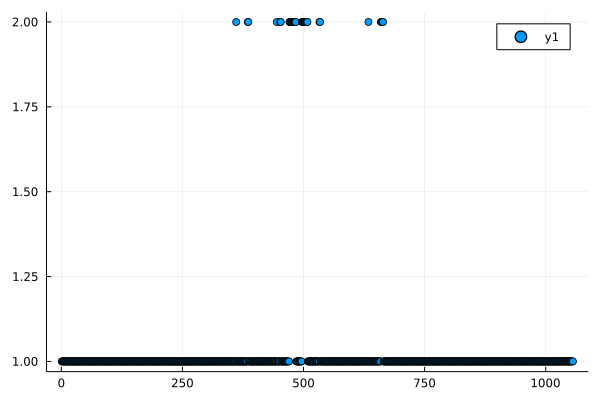

In [8]:
scatter(lowest_fe)

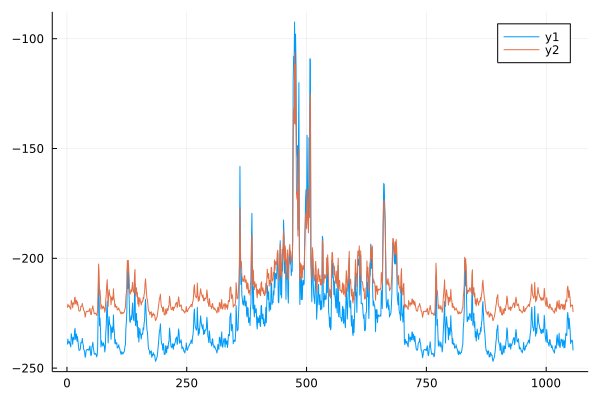

In [9]:
plot(fe_br[:, end])
plot!(fe_tr[:, end])

In [28]:
function model_posteriors(m_lh, m_pr)
    model_evidence = mapreduce(x -> x[1]*x[2], +, zip(m_lh, m_pr))
    posteriors = map(x -> x[1]*x[2], zip(m_lh, m_pr)) ./ model_evidence
end

model_posteriors (generic function with 1 method)

### Markov model

In [29]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples, Â, B̂; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = Â
    # Observation noise
    B = B̂
    # Initial state
    s_0 = zeros(size(A, 1)); s_0[1] = 1.0
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [30]:
function create_B(dims)
    base = ones(dims); base[1] = 1e2
    B = hcat(base)'
    for i in 1:dims-1
        base = circshift(base, 1)
        B = vcat(B, hcat(base)')
    end
    B
end

create_B (generic function with 1 method)

In [31]:
@model [ default_factorisation = MeanField() ] function hmm(n, order)
    
    A ~ MatrixDirichlet(ones(order, order)) 
    B ~ MatrixDirichlet(create_B(order))
    
    s_0 ~ Categorical(fill(1.0 / order, order))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

hmm (generic function with 1 method)

In [32]:
function inference_hmm(data, vmp_iter, order)
    n = length(data)
    
    model, (s, x, A, B) = hmm(n, order, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, order, order))
    setmarginal!(B, MatrixDirichlet(create_B(order)))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    ProgressMeter.@showprogress for i in 1:vmp_iter
        update!(x, data)
    end
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference_hmm (generic function with 1 method)

In [53]:
# classified based on FE
lowest_fe_vec = zeros(length(lowest_fe), 2)
for (index, l_fe) in enumerate(eachrow(lowest_fe_vec))
    l_fe[lowest_fe[index]] = 1.0
end

In [47]:
x_data = [lowest_fe_vec[i,:] for i in 1:size(lowest_fe_vec,1)]

528-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 ⋮
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]

In [42]:
A = [0.5 0.5; 0.5 0.5] 
B = [0.9 0.1; 0.1 0.9] 
x_data, s_data = generate_data(100, A, B);

In [54]:
s, A, B, fe = inference_hmm(x_data, 100, 2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [55]:
mean(A[end])

2×2 Matrix{Float64}:
 0.983153   0.301039
 0.0168471  0.698961

In [56]:
mean(B[end])

2×2 Matrix{Float64}:
 0.995758    0.017545
 0.00424221  0.982455

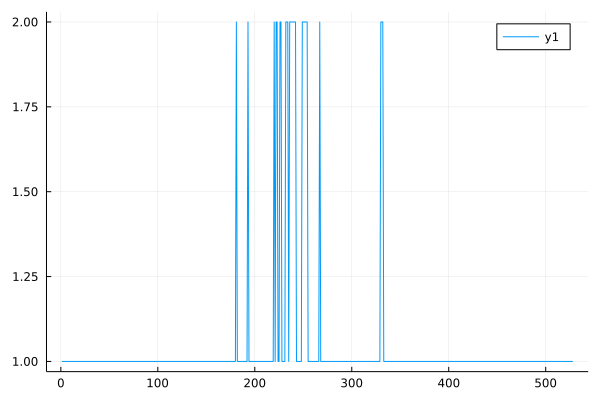

In [58]:
plot(round.(mean.(s[end])))
plot(lowest_fe)